In [ ]:
# Project configuration - use absolute paths
from pathlib import Path
PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
print(f"Project root: {PROJECT_ROOT}")

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
import os

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom UNet2DConditionModel with reduced parameters
class CustomUNet2DConditionModel(UNet2DConditionModel):
    def __init__(self, **kwargs):
        super().__init__(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # Reduced from default
            block_out_channels=(32, 64, 64, 32),  # Reduced from default
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
            cross_attention_dim=512,  # CLIP embedding dimension
            **kwargs
        )

# Load models
unet = CustomUNet2DConditionModel().to(device)


In [3]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [4]:
tokenizer.model_max_length ## 77

77

In [5]:
TOKENIZER_MAX_LENGTH = 8
captions_sample = ['"A handwritten digit 1']
text_input = tokenizer(captions_sample, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 8, 512])

In [6]:
num_of_params = sum([p.numel() for p in unet.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 3,140,385


In [ ]:
path_to_dataset = str(PROJECT_ROOT / "dataset_cache")

mnist_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transforms.ToTensor())

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
train_dataloader = DataLoader(mnist_dataset, batch_size=512, shuffle=True)
next(iter(train_dataloader))[0].shape

torch.Size([512, 1, 28, 28])

In [ ]:
# Training parameters
# num_epochs = 100
num_epochs = 20
# learning_rate = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Track training loss
training_losses = []

# Save initial checkpoint at epoch 0 (before training)
checkpoint_dir = PROJECT_ROOT / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
initial_ckpt = {
    "epoch": 0,
    "unet_state_dict": unet.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_losses": training_losses,
}
torch.save(initial_ckpt, str(checkpoint_dir / "train1_unet_checkpoint_epoch_0.pt"))
print(f"Saved initial checkpoint: {checkpoint_dir / 'train1_unet_checkpoint_epoch_0.pt'}")

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images = images.to(device)

        # Create text captions from labels
        captions = [f"A handwritten digit {label}" for label in labels]

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Track loss
        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    training_losses.append(avg_epoch_loss)
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt = {
            "epoch": epoch + 1,
            "unet_state_dict": unet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "training_losses": training_losses,
        }
        torch.save(ckpt, str(checkpoint_dir / f"train1_unet_checkpoint_epoch_{epoch+1}.pt"))
        print(f"Saved checkpoint: {checkpoint_dir / f'train1_unet_checkpoint_epoch_{epoch+1}.pt'}")

    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}")

Saved initial checkpoint: ./checkpoints/unet_checkpoint_epoch_0.pt


Epoch 1/20: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]


Epoch 1/20, Average Loss: 0.090613


Epoch 2/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 2/20, Average Loss: 0.041418


Epoch 3/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Epoch 3/20, Average Loss: 0.035816


Epoch 4/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 4/20, Average Loss: 0.032826


Epoch 5/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Saved checkpoint: ./checkpoints/unet_checkpoint_epoch_5.pt
Epoch 5/20, Average Loss: 0.031834


Epoch 6/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 6/20, Average Loss: 0.030777


Epoch 7/20: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]


Epoch 7/20, Average Loss: 0.029779


Epoch 8/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 8/20, Average Loss: 0.029267


Epoch 9/20: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]


Epoch 9/20, Average Loss: 0.028803


Epoch 10/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Saved checkpoint: ./checkpoints/unet_checkpoint_epoch_10.pt
Epoch 10/20, Average Loss: 0.028177


Epoch 11/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 11/20, Average Loss: 0.027632


Epoch 12/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Epoch 12/20, Average Loss: 0.027388


Epoch 13/20: 100%|██████████| 118/118 [00:40<00:00,  2.93it/s]


Epoch 13/20, Average Loss: 0.027240


Epoch 14/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Epoch 14/20, Average Loss: 0.026816


Epoch 15/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Saved checkpoint: ./checkpoints/unet_checkpoint_epoch_15.pt
Epoch 15/20, Average Loss: 0.026803


Epoch 16/20: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]


Epoch 16/20, Average Loss: 0.026176


Epoch 17/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 17/20, Average Loss: 0.026346


Epoch 18/20: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]


Epoch 18/20, Average Loss: 0.026138


Epoch 19/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Epoch 19/20, Average Loss: 0.026287


Epoch 20/20: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]


Saved checkpoint: ./checkpoints/unet_checkpoint_epoch_20.pt
Epoch 20/20, Average Loss: 0.026373


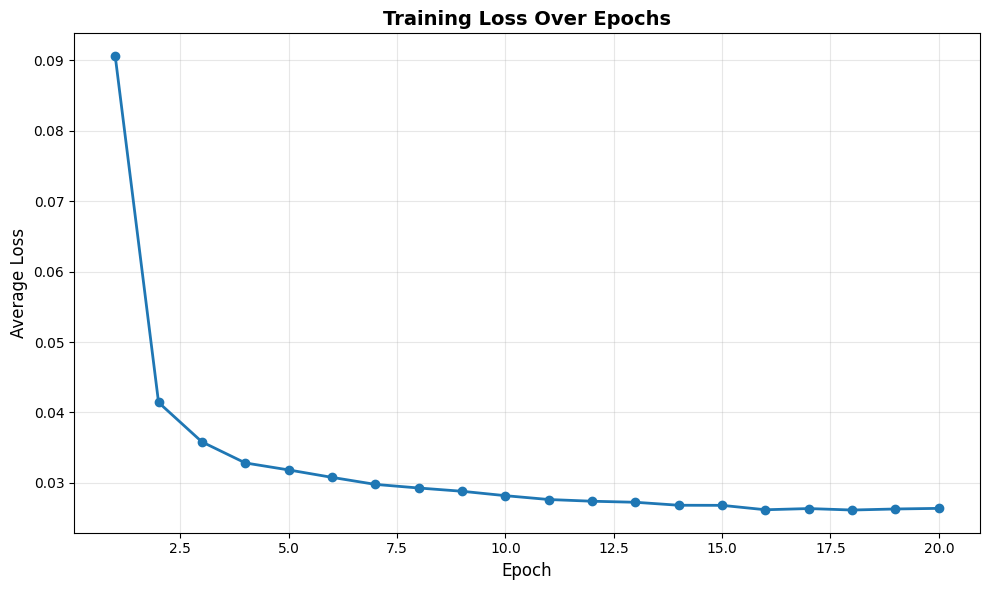


Training Statistics:
Initial Loss (Epoch 1): 0.090613
Final Loss (Epoch 20): 0.026373
Loss Reduction: 70.89%


In [9]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nTraining Statistics:")
print(f"Initial Loss (Epoch 1): {training_losses[0]:.6f}")
print(f"Final Loss (Epoch {len(training_losses)}): {training_losses[-1]:.6f}")
print(f"Loss Reduction: {((training_losses[0] - training_losses[-1]) / training_losses[0] * 100):.2f}%")